#  Multinomial responses - simulations

### Econometrics B (ØkB)

(Wooldridge Ch. 16)

Bertel Schjerning

Department of Economics, University of Copenhagen


### Libraries

In [1]:
%reset -f
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np

# routines for simulation and estimation of conditional logit
from discrete_choice import *  

### Simulate data and estimate conditional logit

In [20]:
J=5             # number of alternatives index j=0,..,J-1
N=10000         # number of observations
theta=np.array([1, -1, 2]).reshape(-1,1)  # True parameters
dta=sim_data(N, J, theta);
res=clogit(dta['y'], dta['x'], deriv=1)  # Estimate c-logit model

Conditional logit
Initial log-likelihood -1.6094379124340998
Initial gradient
 [0.83625446 0.11008878 1.193493  ]
Dep. var. : y 

parnames      theta_hat          se    t-values         jac
----------  -----------  ----------  ----------  ----------
var0            1.02100     0.01520    67.18379    -0.00001
var1           -1.01632     0.01847   -55.01105     0.00000
var2            2.04196     0.02807    72.73378     0.00001
# of observations : 10000
# log-likelihood. : -6481.654779459288 

Iteration info: 11 iterations, 12 evaluations of objective, and 12 evaluations of gradients
Elapsed time: 0.1146 seconds



### Compute derivatives of conditional Logit

Marginal effects wrt alternative-specific covariates $x_{ik}$

$$\frac{\partial}{\partial x_{ik}}P({y_i=j \mid x_i})
\quad=\quad p_{ij}\left(\mathbb{1}(k=j)-p_{ik}\right)\beta$$

Below we compute derivatives averaged over the sample, i.e. average partial effects (APE)


In [25]:
def APE_var(theta, x, m=0, quiet=False): 
    # matrix of partial derivatibes with respect ot a change in attribute m
    N, J, K, palt, xalt, xvars = labels(x)
    p=ccp(utiliy(theta, x))
    E=np.empty((J,J))
    for j in range(J):
        for k in range(J):
            E[k, j]=np.mean(p[:,j]*theta[m]*(1*(j==k)-p[:,k]), axis=0)
    if not quiet: 
        print('\nAPE wrt change in', xvars[m])
        print(tabulate(np.c_[xalt, E], headers=palt,floatfmt="10.5f"))
    return E

dydx=APE_var(res.theta_hat, dta['x'], m=0)
print('\nckeck: derivatibes should sum to 0 over all alterntives \n', np.sum(dydx,axis=1))


APE wrt change in var0
              p0          p1          p2          p3          p4
----  ----------  ----------  ----------  ----------  ----------
alt0     0.02904    -0.00336    -0.00579    -0.00817    -0.01171
alt1    -0.00336     0.04800    -0.00993    -0.01386    -0.02085
alt2    -0.00579    -0.00993     0.07044    -0.02232    -0.03240
alt3    -0.00817    -0.01386    -0.02232     0.09504    -0.05069
alt4    -0.01171    -0.02085    -0.03240    -0.05069     0.11566

ckeck: derivatibes should sum to 0 over all alterntives 
 [-1.73472348e-18  0.00000000e+00  0.00000000e+00  6.93889390e-18
  0.00000000e+00]


# Compute elasticities
- The elasticity of $p_{ij}$ wrt to a change alternative-specific attribute $x_{ik}$ is

$$E_{j, x_{ik}}= \frac{x_{ik}}{p_{ij}}\frac{\partial p_{ij}}{\partial x_{ik}}
\quad=\quad \frac{x_{ik}}{p_{ij}}  p_{ij}\left(\mathbb{1}(k=j)-p_{ik}\right)\beta 
\quad=\quad \left(\mathbb{1}(k=j)-p_{ik}\right) x_{ik}\beta $$
- **Own elasticity** (i.e. when $k=j$)

$$E_{j, x_{ik}}= 
\quad=\quad (1-p_{ik})x_{ik}\beta $$

- **The cross-price elasticity** (i.e. when $k\ne j$) is completely independent of $j$ (due to IIA)

$$E_{j, x_{ik}}= 
\quad=\quad -p_{ik} x_{ik}\beta $$



In [26]:
def Ematrix_var(theta, x, m=1, quiet=False):
    # matrix of elasticities with respect ot a change in attribute m
    N, J, K, palt, xalt, xvars = labels(x)
    p=ccp(utiliy(theta, x))
    E=np.empty((J,J))
    for j in range(J):
        for k in range(J):
            E[k, j]=np.mean(x[:,k,m]*theta[m]*(1*(j==k)-p[:,k]), axis=0)
    if not quiet: 
        print('\nElasticity wrt change in', xvars[m])
        print(tabulate(np.c_[xalt, E], headers=palt,floatfmt="10.5f"))
    return E
E=Ematrix_var(res.theta_hat, dta['x'], m=0)


Elasticity wrt change in var0
              p0          p1          p2          p3          p4
----  ----------  ----------  ----------  ----------  ----------
alt0     2.88616    -0.17730    -0.17730    -0.17730    -0.17730
alt1    -0.39244     3.19511    -0.39244    -0.39244    -0.39244
alt2    -0.72320    -0.72320     3.37004    -0.72320    -0.72320
alt3    -1.34950    -1.34950    -1.34950     3.25803    -1.34950
alt4    -2.30341    -2.30341    -2.30341    -2.30341     2.80506


In [27]:
def Ematrix_own(theta, x, quiet=False):
    # Own elasticity: % change in prob of altertive j wrt % change in attribute of same alternative j
    # done for for each varible in x  
    N, J, K, palt, xalt, xvars = labels(x)
    p=ccp(utiliy(theta, x))
    E_own=np.empty((J, K))
    for iJ in range(J):
        for iK in range(K):
            E_own[iJ, iK]=np.mean(x[:,iJ,iK]*theta[iK]*(1-p[:,iJ]), axis=0)
    if not quiet: 
        print('\nOwn elasticity')
        print(tabulate(np.c_[xalt, E_own], headers=xvars,floatfmt="10.5f"))
    return E_own

E=Ematrix_own(res.theta_hat, dta['x'])



Own elasticity
            var0        var1        var2
----  ----------  ----------  ----------
alt0     2.88616    -2.91945     5.67671
alt1     3.19511    -3.26567     6.26797
alt2     3.37004    -3.50602     6.58151
alt3     3.25803    -3.42750     6.30341
alt4     2.80506    -3.02575     5.41017


In [28]:
def Ematrix_cross(theta, x, quiet=False):
    # Cross elasticity:  % change in prob of altertive j wrt % change in attribute of other alternative k ne j
    # done for each varible in x  
    N, J, K, palt, xalt, xvars = labels(x)
    p=ccp(utiliy(theta, x))
    E_cross=np.empty((J, K))
    for iJ in range(J):
        for iK in range(K):
            E_cross[iJ, iK]=np.mean(x[:,iJ,iK]*theta[iK]*(-p[:,iJ]), axis=0)
    if not quiet: 
        print('\nCross-Elasticity')
        print(tabulate(np.c_[xalt, E_cross], headers=xvars,floatfmt="10.5f"))
    
E=Ematrix_cross(res.theta_hat, dta['x'])


Cross-Elasticity
            var0        var1        var2
----  ----------  ----------  ----------
alt0    -0.17730     0.11923    -0.41454
alt1    -0.39244     0.28408    -0.88287
alt2    -0.72320     0.58306    -1.58775
alt3    -1.34950     1.13758    -2.89382
alt4    -2.30341     2.05202    -4.82730


In [29]:
# MAKE NEW SIMULATION, ESTIMATE AND COMPARE OUTPUT
theta=np.array([1, 2]).reshape(-1,1)*1
K= theta.shape[0]
N=1000
J=3
dta=sim_data(N, J, theta) 
res=clogit(dta['y'], dta['x'], deriv=1, quiet=False)

for m in range(K): 
    E=Ematrix_var(res.theta_hat, dta['x'], m=0)
E=Ematrix_own(res.theta_hat, dta['x'])
E=Ematrix_cross(res.theta_hat, dta['x'])

Conditional logit
Initial log-likelihood -1.0986122886681096
Initial gradient
 [0.88315749 1.09766235]
Dep. var. : y 

parnames      theta_hat          se    t-values         jac
----------  -----------  ----------  ----------  ----------
var0            0.96042     0.07209    13.32177     0.00000
var1            1.89826     0.11367    16.69906    -0.00000
# of observations : 1000
# log-likelihood. : -332.92128236727854 

Iteration info: 12 iterations, 13 evaluations of objective, and 13 evaluations of gradients
Elapsed time: 0.0201 seconds


Elasticity wrt change in var0
              p0          p1          p2
----  ----------  ----------  ----------
alt0     2.76994    -0.12473    -0.12473
alt1    -0.85154     3.03899    -0.85154
alt2    -3.72233    -3.72233     1.04367

Elasticity wrt change in var0
              p0          p1          p2
----  ----------  ----------  ----------
alt0     2.76994    -0.12473    -0.12473
alt1    -0.85154     3.03899    -0.85154
alt2    -3.72233    -

## Monte Carlo Experiment
Analysis of properties of MLE estimator for conditional logit

In [36]:
# MONTECARLO

# Parameters for experimental design
theta=np.array([1, 2]).reshape(-1,1)*1
K= theta.shape[0]
N=1000
J=10 
nM=2000 # number of monte carlo samples

# run experiments
for iM in range(nM): 
    dta=sim_data(N, J, theta) # simulate data - make sure seed is not fixed
    res_im=clogit(dta['y'], dta['x'], deriv=1, quiet=True) # etstimate model and save results
    if iM==0: 
        res=res_im  # initialize results dict
    res[iM]=res_im  # save results for each iM 
print('Monte Carlo done')

Monte Carlo done


In [37]:
# Compile results and print summary output
# Does theta_hat and se seem to be unbiased estimators for theta and the standard error? 
MC_theta=np.empty((nM,K))
MC_se=np.empty((nM,K))
for iM in range(nM): 
    MC_theta[iM,:]=res[iM].theta_hat.T
    MC_se[iM,:]=res[iM].se.T

print('theta_true:\n'       , theta.T)
print('E(theta_hat):\n'       , np.mean(MC_theta, 0))
print('E(theta_hat-theta_true):\n' , np.mean(MC_theta, 0)-theta.T)
print('Monte Carlo Standard Devivation, std(theta_hat):\n'       , np.std(MC_theta, 0))
print('E(se):\n' , np.mean(MC_se, 0))

theta_true:
 [[1 2]]
E(theta_hat):
 [1.00253922 2.00507388]
E(theta_hat-theta_true):
 [[0.00253922 0.00507388]]
Monte Carlo Standard Devivation, std(theta_hat):
 [0.05220186 0.07363804]
E(se):
 [0.04766627 0.07081771]


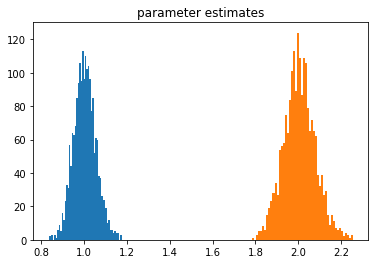

In [38]:
import matplotlib.pyplot as plt
# Plot montecarlo distribution theta_hat
# Does distribution look approximately normal as theory would predict?
for i in range(K):
    plt.title('parameter estimates')
    plt.hist(MC_theta[:,i], bins = 50)
plt.show()

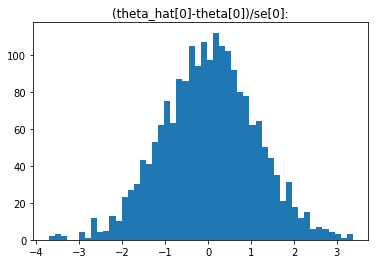

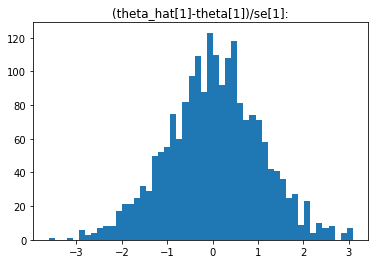

In [39]:
# Plot montecarlo distribution of test for hypothesis that theta_hat=theta
# Does distribution look approximately standard normal as theory would predict?
for i in range(K):
    plt.title('(theta_hat[%d]-theta[%d])/se[%d]:' % (i,i,i))
    plt.hist((MC_theta[:,i]-theta[i])/MC_se[:,i], bins = 50)
    plt.show()

### Other things to try out in Monte Carlo
- What happens as $N$ go to infinity
    - Can you verify that the MLE estimator $\hat{\theta}$ is $\sqrt(N)$-consistent for $\theta$
    - You may want run a sequence of experiments for different values of N and plot mean and standard derivation of $\sqrt{N}(\hat{\theta}-\theta)$ against $N$
    -  What happens if you do not multiply with $\sqrt{N}$
    
- What happens as $J$ increase (will standard error increase or fall)

- What about the distribution of other statistics (elasticities, derivatives, etc)

- What happens if logit is misspecified
    - neglegted heterogeneity
    - correlation accross alterntives
    - what can you estimate (parameters, elasticities, derivatives, etc)